# TFM: 
## Degradación de un sistema fotovoltáico 
## Luis Julián García Giménez

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

'''
path_i='/Users/LuisGarcia/Desktop/TFM/interpolados/'
path_ni='/Users/LuisGarcia/Desktop/TFM/no_interpolados/'
path_ima='/Users/LuisGarcia/Desktop/TFM/imagenes/degradacion'
'''

'''
path_ni='/Users/LuisGarcia/Desktop/TFM/no_interpolados_no_z_n/'
path_ima='/Users/LuisGarcia/Desktop/TFM/imagenes_no_z_n/degradacion/'
'''

path_ni='/Users/LuisGarcia/Desktop/TFM/no_interpolados_no_z_n_cc/'
path_ima='/Users/LuisGarcia/Desktop/TFM/imagenes_no_z_n_cc/degradacion/'

df1_ni=pd.read_csv(path_ni + 'df1_ni.csv')
df2_ni=pd.read_csv(path_ni + 'df2_ni.csv')
df3_ni=pd.read_csv(path_ni + 'df3_ni.csv')
df4_ni=pd.read_csv(path_ni + 'df4_ni.csv')

#RENOMBRAR COLUMNAS
#media_poa --> poa
#media_temp --> Tcell
df1_ni = df1_ni.rename(columns = {"media_poa": "poa" , "media_temp": "Tcell"})
df2_ni = df2_ni.rename(columns = {"media_poa": "poa" , "media_temp": "Tcell"})
df3_ni = df3_ni.rename(columns = {"media_poa": "poa" , "media_temp": "Tcell"})
df4_ni = df4_ni.rename(columns = {"media_poa": "poa" , "media_temp": "Tcell"})

In [4]:
from scipy.stats import median_test


def representar_graficas(x, mediana, df_str, y_label):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x,mediana, label ="Mediana")
    ax.set_xlabel('Años')
    ax.set_ylabel(y_label)
    ax.title.set_text(df_str)
        
    nombre_img="representar_graficas_" + df_str + ".png"
    plt.savefig(path_ima + nombre_img)

#----------------------------------FASE 1----------------------------------------------------
#FILTRAR POA >  200

def filtrar_poa(df):
    mask = (df.poa > 200)
    print("Filas antes de eliminar los poa > 200: ", len(df))
    df_filtrado=df.loc[mask]
    print("Filas despues de eliminar los poa > 200: ", len(df_filtrado))
    return df_filtrado
#--------------------------------------------------------------------------------------------

#FILTRAMOS POR POA > 200
poa_200_df1=filtrar_poa(df1_ni)
poa_200_df2=filtrar_poa(df2_ni)
poa_200_df3=filtrar_poa(df3_ni)
poa_200_df4=filtrar_poa(df4_ni)

#--------------------------------------------------------------------------------------------
print()
numero_intervalos=5
print("Filas df1 no interpolado: ", len(poa_200_df1))
muestras_intervalos= len(poa_200_df1)/numero_intervalos
print ("Si dividimos en 5 intervalos, cada intervalo tiene aproximadamente: ", muestras_intervalos, " valores")
print("------------------------------------------------")
print()
#--------------------------------------------------------------------------------------------

def generar_buckets(df, bins_poa, bins_tcell, df_str):
    
    #df_filtrado=filtrar_poa(df)
    
    #----------------------------------FASE 2----------------------------------------------------
    #Generar buckets
    
    '''
    Primero creamos los buckets de poa y luego los de tcell, dentro de cada bucket de poa.
    En primer lugar hacemos un qcut de poa y añadimos las etiquetas de buckets al dataframe original.
    bucket_i=df[df.bucket_poa == i] --> Para cada una de las divisiones que hago de poa selecciono un dataframe pequeño. Ese dataframe son los datos que esán en el mismo rango de poa. 
    b_tcell=pd.qcut(bucket_i, q= bins_tcell, labels= False) --> el bucket_i que acabamos de generar, lo dividimos a su vez en buckets, por temperatura.
    b_tcell es una lista de valores que dice a qué bucket le corresponde cada fila de bucket_i
    bucket_i["bucket_tcell"]= b_tcell --> en el mismo dataframe: bucket_i añadimos la la columna "bucket_tcell" que va a contenener las etiquetas de los subbuckets.
    El problema que tiene hacer esto es que la siguiente iteración, se va a cargar el bucket_i, porque vamos a generar otro nuevo bucket_i en la siguiente iteración
    Para solucionar esto: creamos una lista de buckets: "buckets = []" y añadimos los buckets a esa lista:
    buckets.appen(bucket_i.copy())
    Se podría hacer así:
    buckets.appen(bucket_i)
    Pero puede que sea conveniente hacer una copia por la compartición de punteros.
    Por lo que generamos una copia y la vamos metiendo en la lista "buckets"
    
    '''
    #BUCKETS DE POA

    b_poa=pd.qcut(df.poa, q= bins_poa, labels= False)
        
    df["bucket_poa"]= b_poa
    #print(df)
    print("Cada bucket POA tiene el siguiente número de valores: ")
    print(b_poa.value_counts(ascending=True))
    print()
    
    #----------------------INTERVALOS POA-------------------------
    print("INTERVALOS POA")
    lista_min_max_p=[]
    for i in range(bins_poa):
        minimo_p= df[df.bucket_poa==i].poa.min()
        maximo_p =df[df.bucket_poa==i].poa.max()
        tupla_min_max_p=(minimo_p, maximo_p)
        lista_min_max_p.append(tupla_min_max_p)
        print(" El rango de intervalos del bucket: ", i, " es: ", minimo_p, " - ", maximo_p)
    
    print()
    print(lista_min_max_p)
    print("------------------------------------------------")
    print()
    #-------------------------------------------------------------
    
    '''
    #---------------DIVIDIR LOS VALORES EN INTERVALOS------
    for i in range(bins_poa):
        print("------------------------------------------------")
        print(lista_min_max_p)
        print()
        mascara= (df.bucket_poa==i)
        valores_intervalo= df.loc[mascara]
        ordenar = valores_intervalo.sort_values('poa',ascending=True)
        print("valores_intervalo")
        print(ordenar)
    
    #------------------------------------------------------
    '''
        
    #BUCKETS DE TCELL PARA CADA BUCKET DE POA  
    #PARA TODO EL DATASET
    buckets=[]
    todos_intervalos_tcell=[] #vamos a introducir 5 listas en todos_intervalos_tcell. 
    #Cada lista va a contener los 5 intervalos de tcell
    for i in range(bins_poa):
        
        bucket_i=df[df.bucket_poa == i] #ANTES(TURORIA)
        
        #b_tcell=pd.qcut(bucket_i, q= bins_tcell, labels= False)
        b_tcell=pd.qcut(bucket_i.Tcell, q= bins_tcell, labels= False)
        
        print("Cada bucket TCELL tiene el siguiente número de valores: ")
        print(b_tcell.value_counts(ascending=True))
        print()
    
        bucket_i["bucket_tcell"]= b_tcell
        
        #print("bucket_i")
        #print(bucket_i)
        
        buckets.append(bucket_i.copy())
    
        #----------------------INTERVALOS TCELL-------------------------
        #print("------------------------------------------------")
        print("INTERVALOS TCELL")
        lista_min_max_t=[]
        for i in range(bins_tcell):
            minimo_t= bucket_i[bucket_i.bucket_tcell==i].Tcell.min()
            maximo_t= bucket_i[bucket_i.bucket_tcell==i].Tcell.max()
            tupla_min_max_t=(minimo_t, maximo_t)
            lista_min_max_t.append(tupla_min_max_t)
            #print(" El rango de intervalos del bucket: ", i, " es: ", minimo_t, " - ", maximo_t)

        print()
        print(lista_min_max_t)
        todos_intervalos_tcell.append(lista_min_max_t)
        print()
        print("------------------------------------------------")
        #-------------------------------------------------------------
    
    #print("buckets ", buckets)
    
    print()
    print("------------------------------------------------")
    print("INTERVALOS TCELL")
    for i in range(bins_poa):
        print ("Poa = ", i, " intervalo Tcell: " ,todos_intervalos_tcell[i])
    print("------------------------------------------------")
    print()
    #------------------------------------FASE 3--------------------------------------------------
    #Calcular potencia
    tam_total=[]
    potencia_intervalos=[]
    diferencias_intervalos=[]
    diferencia_primero_ultimo=[]
    for bucket in buckets:
        #for t in range(max(bucket.bucket_tcell)+1):
        for t in range(bins_tcell):
            
            bucket_m=bucket[bucket.bucket_tcell == t] #AHORA
            
            #SABER EL NÚMERO DE BUCKET DE POA EN EL QUE ESTAMOS.
            bucket_poa=bucket["bucket_poa"].iloc[0]
            print("Numero bucket poa: ", bucket_poa)
            print("Numero bucket Tcell: ", t)
            
            #inter_p, inter_t=saber_intervalos(bucket_poa, t)
            
            inter_t=todos_intervalos_tcell[bucket_poa][t]
            inter_p=lista_min_max_p[bucket_poa]
            
            print()
            
            tam_bucket=len(bucket_m)
            tam_total.append(tam_bucket) # Tam_total
            print("Tamaño del bucket: ", tam_bucket, " valores")
            print()
            
            #print("bucket_m")
            #print(bucket_m)
             
            #Dento de un bucket de poa, que tiene varios buckets de tcell:
            #Cogemos un bucket de tcell y lo dividimos en los diferentes años. Y obtenemos la mediana de la potencia, para cada año.
            años=['2013', '2014','2015', '2016', '2017', '2018', '2019', '2020']
            medianas_power=[]
            for i in años:
                fecha_inicio= i + '-01-01'
                fecha_fin= i + '-12-31'
                mask = (bucket_m.Timestamp > fecha_inicio) & (bucket_m.Timestamp <= fecha_fin)
                mediana_power=bucket_m['power'].loc[mask].median()
                medianas_power.append(mediana_power)
            
            print("medianas_power ", medianas_power)
            print()
            
            #GUARDO TODAS LAS LISTAS DE MEDIANAS DE POTENCIA
            potencia_intervalos.append(medianas_power)
            
            #---------DIFERENCIA ENTRE EL 1ER Y ULTIMO AÑO---------
            dif=abs(medianas_power[0]-medianas_power[-1])*100/medianas_power[0] #resta de la mediana del primer año  y de la mediana del último
            difer=dif/7 #difer=dif/(años-1) = dif/ (8 años-1) Es la diferencia anual lo que queremos obtener.
            diferencia_primero_ultimo.append(difer)
            #dif en %
            if difer > 1: #1%
                print("La diferencia entre el primer y el ultimo año: " , difer, " % es mayor al 1%")
            else:
                print("La diferencia entre el primer y el ultimo año: " , difer, " % es menor al 1%")
            #-------------------------------------------------------
            
            diferencias=[]
            for i in range(len(años)-1):
                diferencia=abs(medianas_power[i]-medianas_power[i+1])*100/medianas_power[i]
                diferencias.append(diferencia)
                
            print()
            print("Diferencias:")
            print(diferencias)
            
            
            #GUARDO TODAS LAS LISTAS DE DIFERENCIAS
            diferencias_intervalos.append(diferencias)
            

            titulo= df_str + "\n bucket_poa: " + str(bucket_poa) + "   Intervalo: " + str(inter_p) +"\n bucket_Tcell: " + str(t) + "   Intervalo: " + str(inter_t)
            representar_graficas(años, medianas_power, titulo, 'Potencia')

            print("------------------------------------------------")
            print()
    
    #---------DISTRIBUCIÓN DE VALORES----------------
    print("Distribución de los valores en los intervalos")
    print()
    pos=0
    for i in range(bins_poa):
        for k in range(bins_tcell):
            print("Intervalo: Poa" + str(lista_min_max_p[i]) + " Tcell" + str(lista_min_max_t[k]) + ": " + str(tam_total[pos]) + " valores")
            pos=pos+1
    #------------------------------------------------
    #AÑADIDO
    print("------------------------------------------------")
    print("Las diferencias en % entre el primer año y el último en los 25 buckets son: ")
    print()
    print(diferencia_primero_ultimo)
    print()
    print("La media de todas estas diferencias entre el primer año y el último es: ")
    media_diferencia_primero_ultimo=sum(diferencia_primero_ultimo) / len(diferencia_primero_ultimo)
    print(media_diferencia_primero_ultimo, " %")
    print("------------------------------------------------")
    
    return potencia_intervalos, diferencias_intervalos


#potencia_intervalos, diferencias_intervalos=generar_buckets(poa_200, 5, 5, "df1_ni")

Filas antes de eliminar los poa > 200:  112179
Filas despues de eliminar los poa > 200:  72262
Filas antes de eliminar los poa > 200:  119965
Filas despues de eliminar los poa > 200:  76091
Filas antes de eliminar los poa > 200:  120053
Filas despues de eliminar los poa > 200:  76766
Filas antes de eliminar los poa > 200:  120354
Filas despues de eliminar los poa > 200:  77159

Filas df1 no interpolado:  72262
Si dividimos en 5 intervalos, cada intervalo tiene aproximadamente:  14452.4  valores
------------------------------------------------



Cada bucket POA tiene el siguiente número de valores: 
1    14451
2    14452
3    14452
4    14453
0    14454
Name: poa, dtype: int64

INTERVALOS POA
 El rango de intervalos del bucket:  0  es:  200.01  -  343.25
 El rango de intervalos del bucket:  1  es:  343.26  -  515.42
 El rango de intervalos del bucket:  2  es:  515.43  -  683.16
 El rango de intervalos del bucket:  3  es:  683.17  -  844.12
 El rango de intervalos del bucket:  4  es:  844.14  -  999.99

[(200.01, 343.25), (343.26, 515.42), (515.43, 683.16), (683.17, 844.12), (844.14, 999.99)]
------------------------------------------------

Cada bucket TCELL tiene el siguiente número de valores: 
4    2883
2    2888
1    2891
0    2894
3    2898
Name: Tcell, dtype: int64

INTERVALOS TCELL

[(0.44, 18.53), (18.54, 22.97), (22.98, 27.11), (27.12, 31.82), (31.83, 46.46)]

------------------------------------------------
Cada bucket TCELL tiene el siguiente número de valores: 
3    2883
4    2889
2    2890
1    2894
0    2895
Name

<ipython-input-4-e30c60aa0d60>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bucket_poa"]= b_poa
<ipython-input-4-e30c60aa0d60>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucket_i["bucket_tcell"]= b_tcell



[(0.96, 28.81), (28.82, 33.24), (33.25, 37.29), (37.3, 42.04), (42.05, 57.48)]

------------------------------------------------
Cada bucket TCELL tiene el siguiente número de valores: 
4    2885
1    2888
3    2890
0    2894
2    2895
Name: Tcell, dtype: int64

INTERVALOS TCELL

[(12.46, 33.45), (33.46, 38.22), (38.23, 42.32), (42.33, 46.71), (46.72, 60.99)]

------------------------------------------------
Cada bucket TCELL tiene el siguiente número de valores: 
4    2886
1    2889
0    2892
2    2892
3    2894
Name: Tcell, dtype: int64

INTERVALOS TCELL

[(13.85, 40.24), (40.25, 45.02), (45.03, 48.83), (48.84, 52.2), (52.21, 63.79)]

------------------------------------------------

------------------------------------------------
INTERVALOS TCELL
Poa =  0  intervalo Tcell:  [(0.44, 18.53), (18.54, 22.97), (22.98, 27.11), (27.12, 31.82), (31.83, 46.46)]
Poa =  1  intervalo Tcell:  [(0.73, 23.32), (23.33, 27.97), (27.98, 32.53), (32.54, 37.25), (37.26, 50.79)]
Poa =  2  intervalo Tc

<ipython-input-4-e30c60aa0d60>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,4))


------------------------------------------------

Numero bucket poa:  4
Numero bucket Tcell:  1

Tamaño del bucket:  2889  valores

medianas_power  [158213.3729, 158369.74355, 154030.0909, 152775.76175, 151937.6649, 150619.745, 150661.07489999998, 149721.12289999993]

La diferencia entre el primer y el ultimo año:  0.7667990064249366  % es menor al 1%

Diferencias:
[0.0988352925759705, 2.740203117541768, 0.814340329653084, 0.5485797225946424, 0.8674082893582814, 0.02743989508147318, 0.6238851014596396]
------------------------------------------------

Numero bucket poa:  4
Numero bucket Tcell:  2

Tamaño del bucket:  2892  valores

medianas_power  [157959.21899999998, 154830.8556, 153562.77599999998, 151849.26690000002, 149018.59554999997, 146240.69199999998, 148659.09845, 151488.07545]

La diferencia entre el primer y el ultimo año:  0.585245409811393  % es menor al 1%

Diferencias:
[1.9804880144412293, 0.8190096186486657, 1.115836236250357, 1.8641323779746528, 1.8641321505864834, 1.6

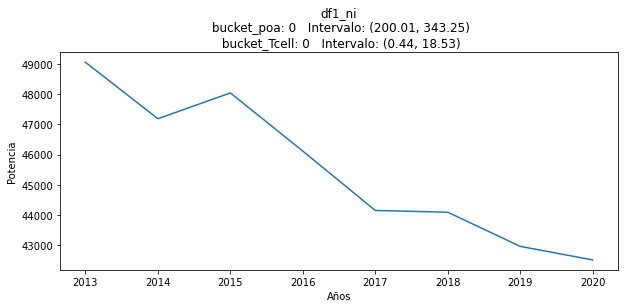

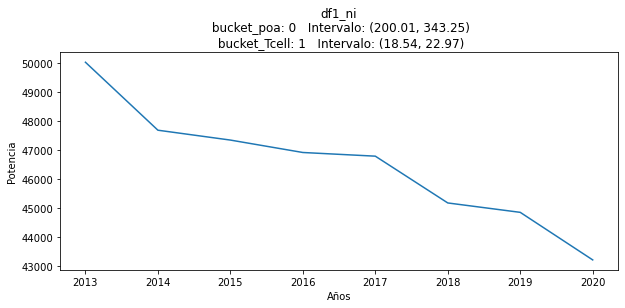

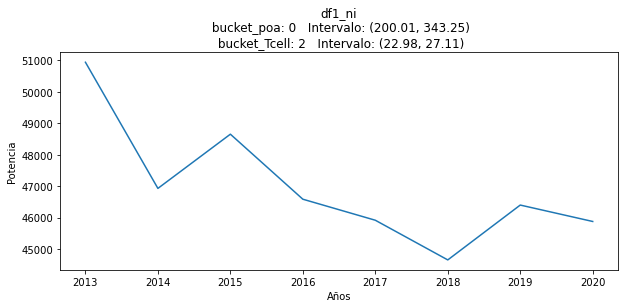

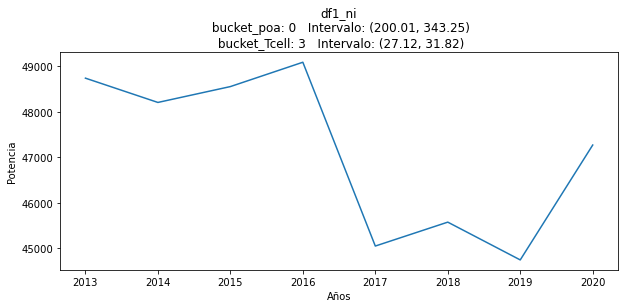

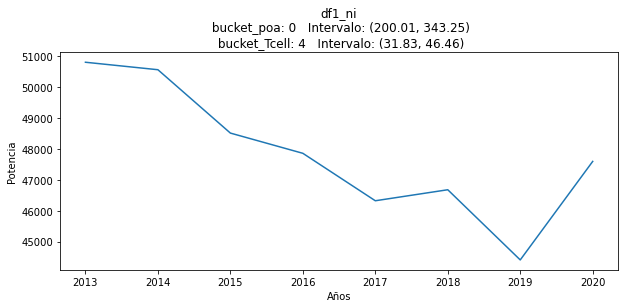

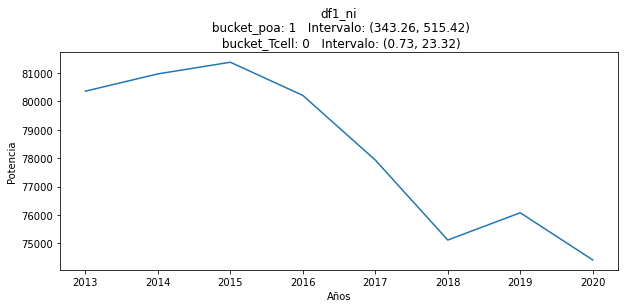

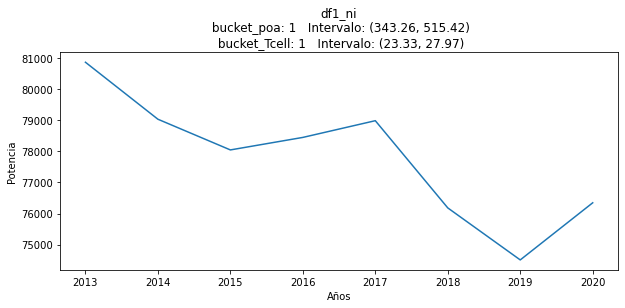

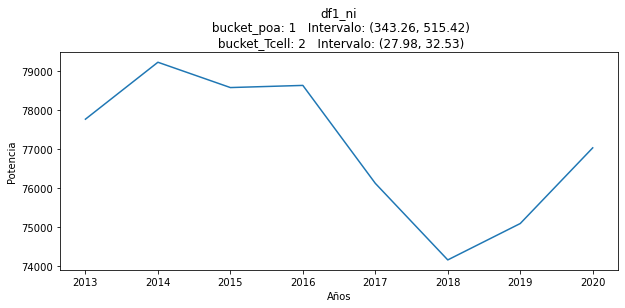

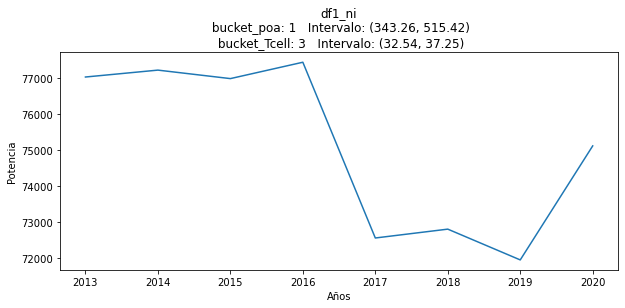

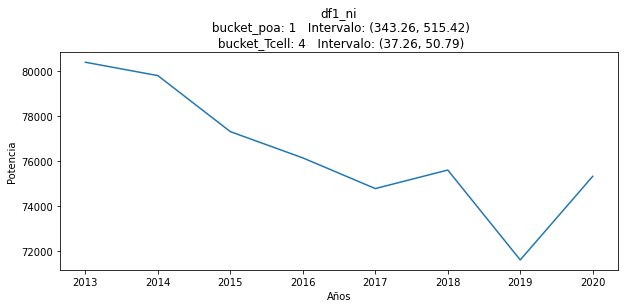

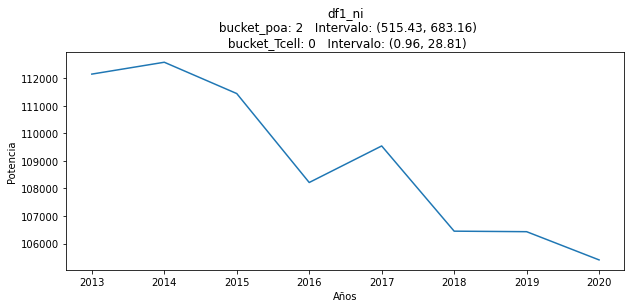

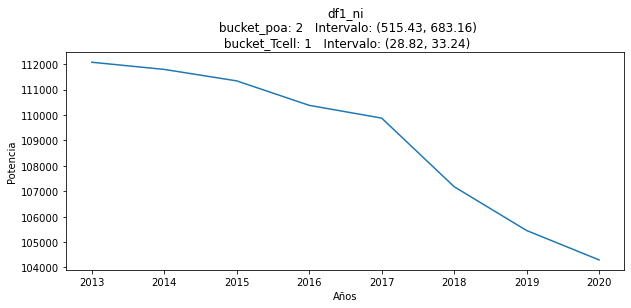

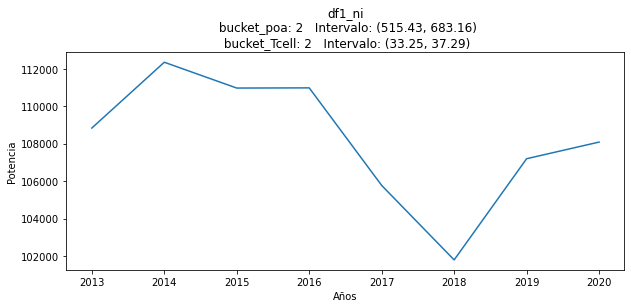

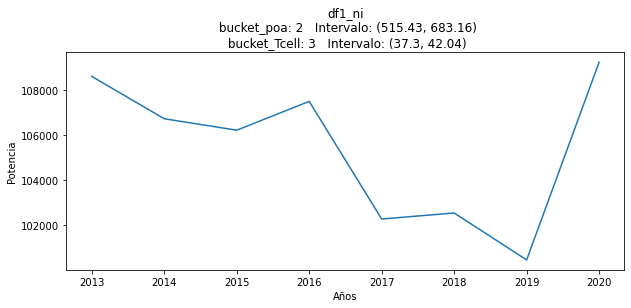

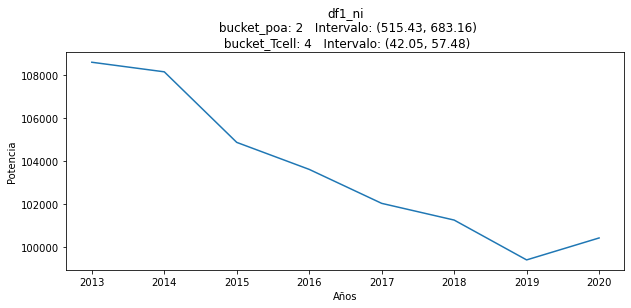

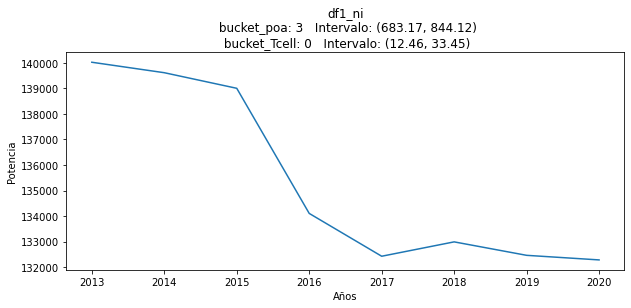

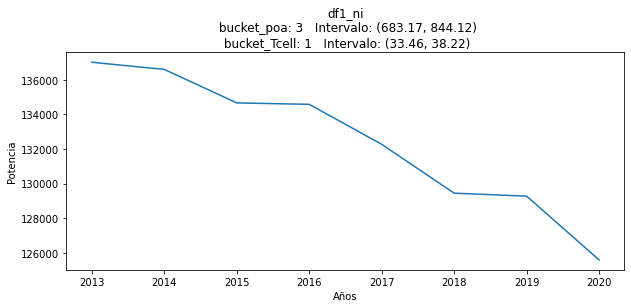

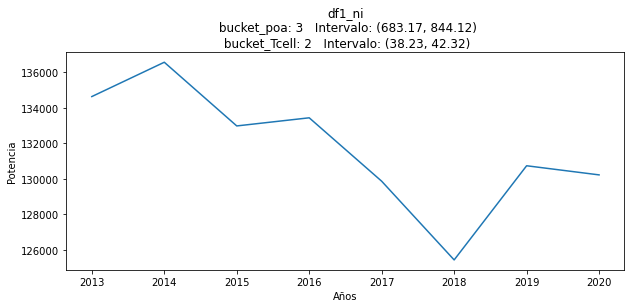

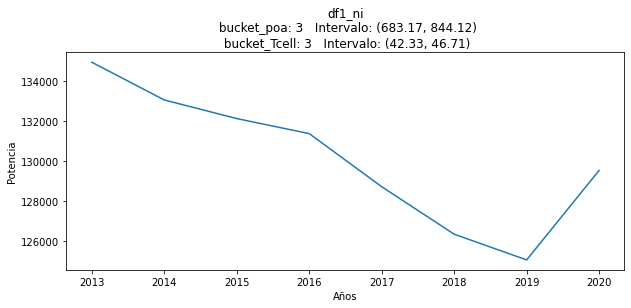

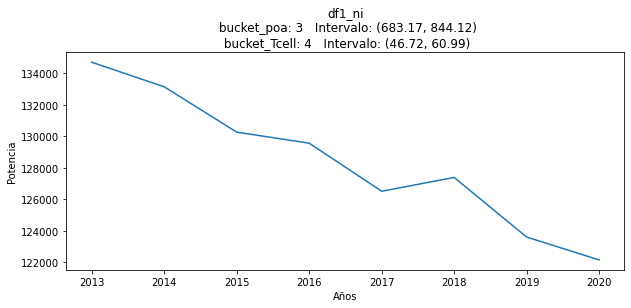

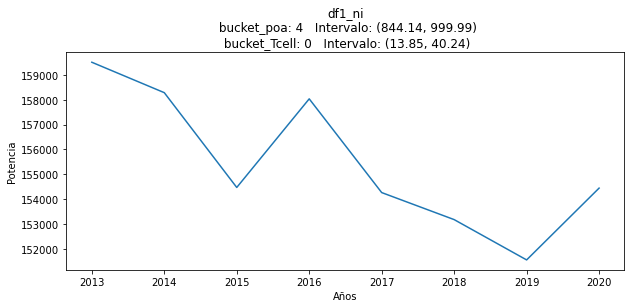

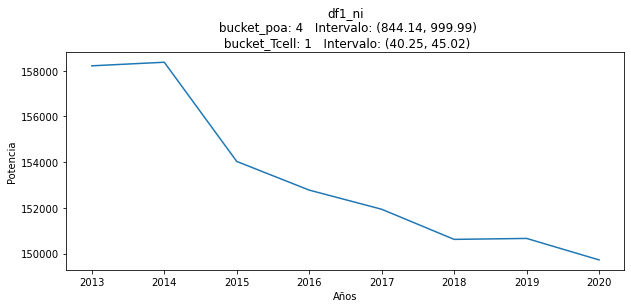

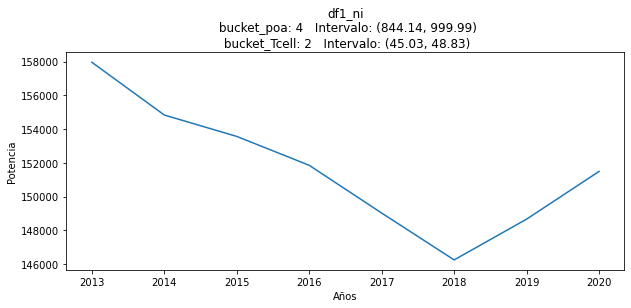

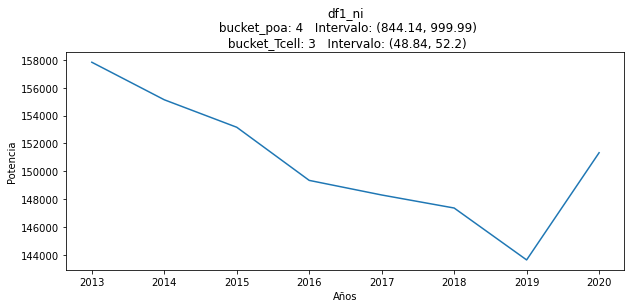

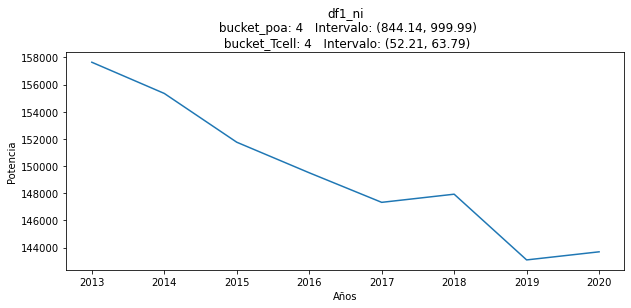

In [5]:
potencia_intervalos, diferencias_intervalos=generar_buckets(poa_200_df1, 5, 5, "df1_ni")

<ipython-input-4-e30c60aa0d60>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bucket_poa"]= b_poa
<ipython-input-4-e30c60aa0d60>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucket_i["bucket_tcell"]= b_tcell


Cada bucket POA tiene el siguiente número de valores: 
4    15217
1    15218
2    15218
0    15219
3    15219
Name: poa, dtype: int64

INTERVALOS POA
 El rango de intervalos del bucket:  0  es:  200.01  -  344.94
 El rango de intervalos del bucket:  1  es:  344.95  -  518.21
 El rango de intervalos del bucket:  2  es:  518.23  -  686.89
 El rango de intervalos del bucket:  3  es:  686.9  -  848.65
 El rango de intervalos del bucket:  4  es:  848.66  -  999.99

[(200.01, 344.94), (344.95, 518.21), (518.23, 686.89), (686.9, 848.65), (848.66, 999.99)]
------------------------------------------------

Cada bucket TCELL tiene el siguiente número de valores: 
4    3037
2    3041
1    3042
0    3048
3    3051
Name: Tcell, dtype: int64

INTERVALOS TCELL

[(0.44, 18.78), (18.79, 23.28), (23.29, 27.49), (27.5, 32.17), (32.18, 46.46)]

------------------------------------------------
Cada bucket TCELL tiene el siguiente número de valores: 
3    3039
2    3041
4    3041
0    3044
1    3053
Name: T

<ipython-input-4-e30c60aa0d60>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,4))


------------------------------------------------

Numero bucket poa:  4
Numero bucket Tcell:  1

Tamaño del bucket:  3039  valores

medianas_power  [162658.36255000002, 162495.18690000006, 168628.3329, 168854.23309999998, 166801.572, 168040.11000000002, 169330.78399999999, 168965.3829]

La diferencia entre el primer y el ultimo año:  0.5539235075392401  % es menor al 1%

Diferencias:
[0.10031802081482408, 3.7743554852331123, 0.13396337146613313, 1.215640888780299, 0.7425217791113082, 0.7680749554377047, 0.21579129994460325]
------------------------------------------------

Numero bucket poa:  4
Numero bucket Tcell:  2

Tamaño del bucket:  3050  valores

medianas_power  [162559.44700000001, 162410.484, 168189.14745, 168513.08945, 165974.17729999998, 165975.63345, 165645.48, 165253.36399999994]

La diferencia entre el primer y el ultimo año:  0.23674126162244846  % es menor al 1%

Diferencias:
[0.09163601546947801, 3.5580606052500854, 0.19260576851209316, 1.5066557489905532, 0.0008773352

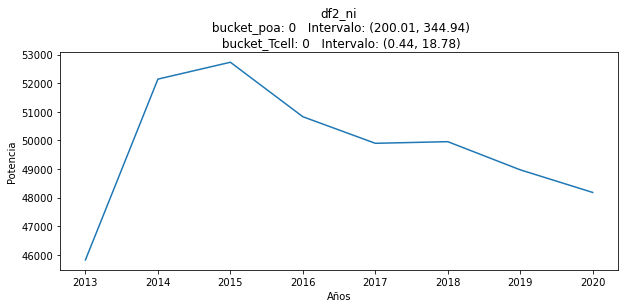

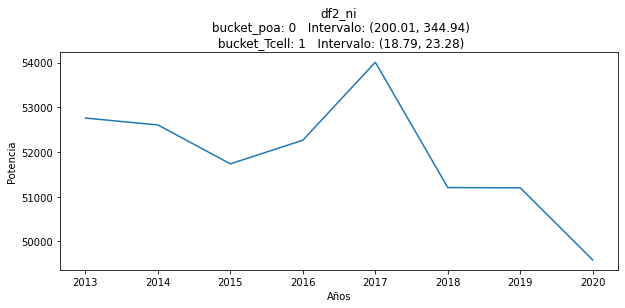

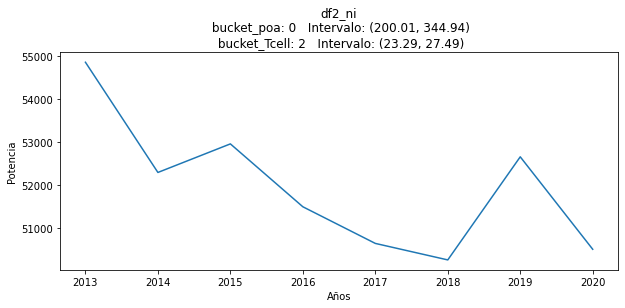

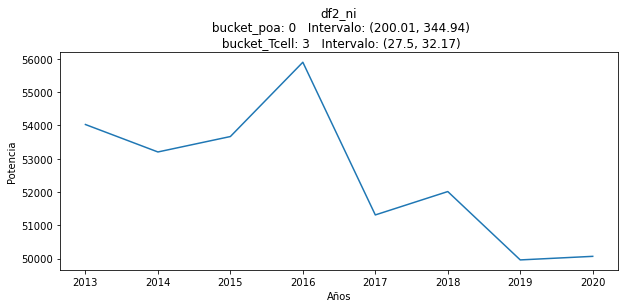

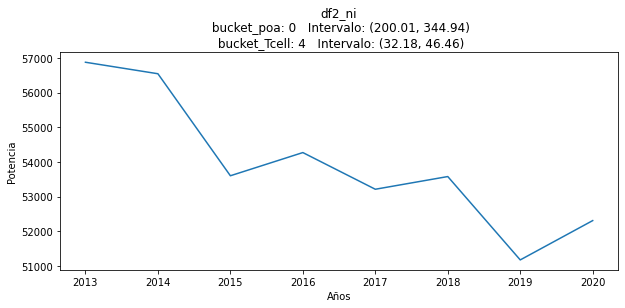

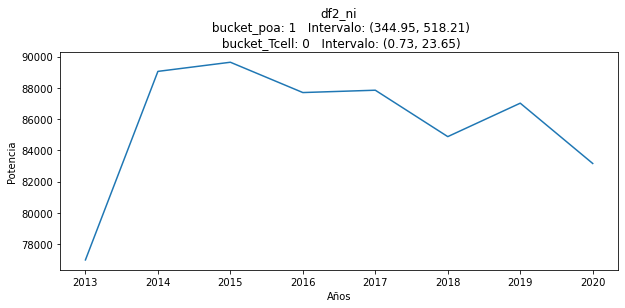

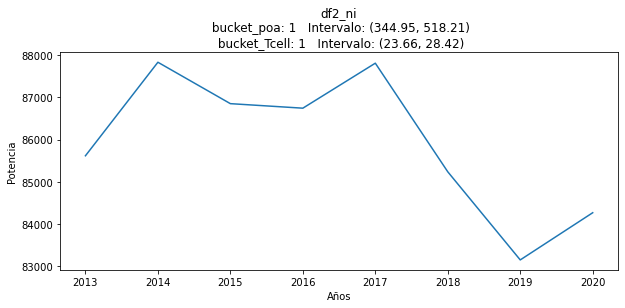

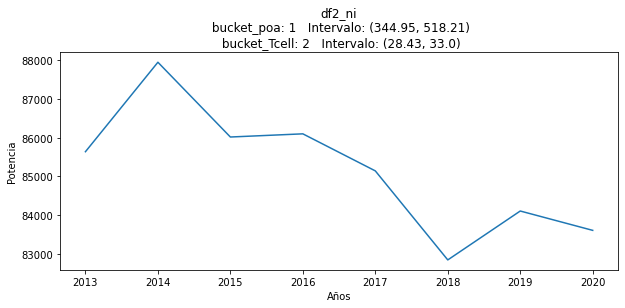

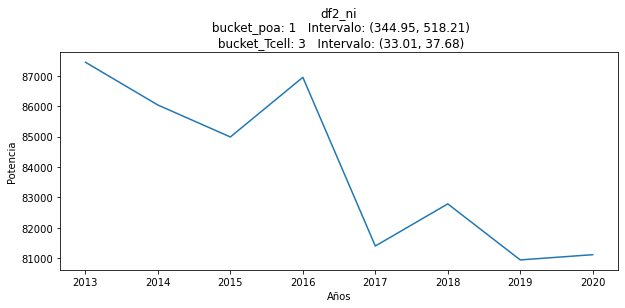

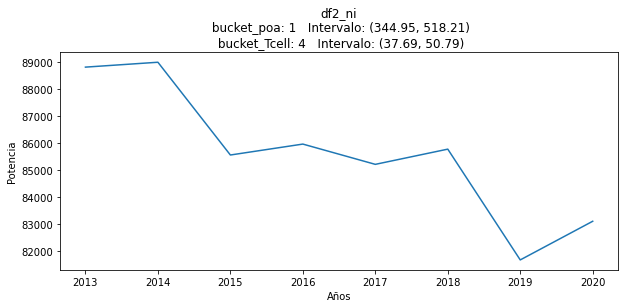

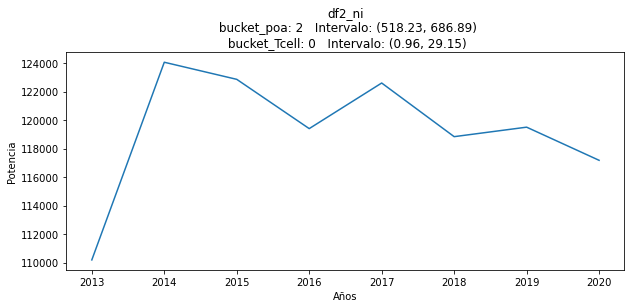

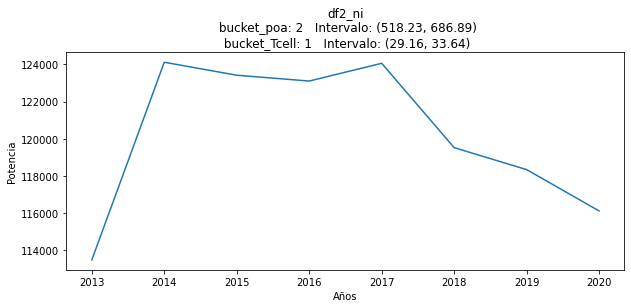

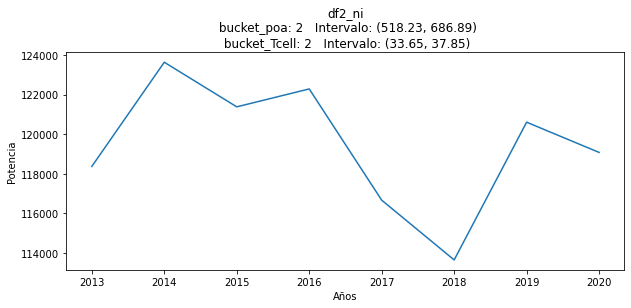

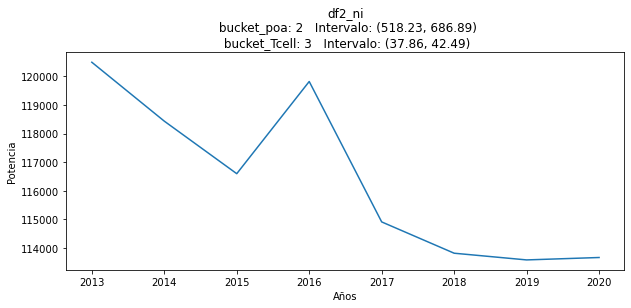

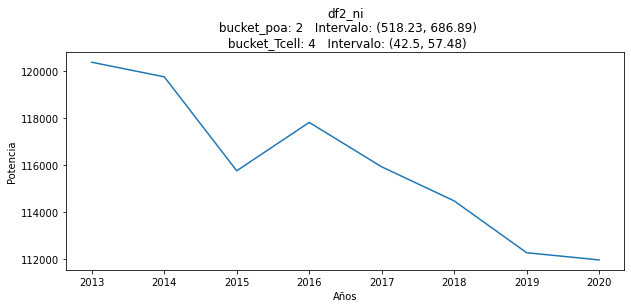

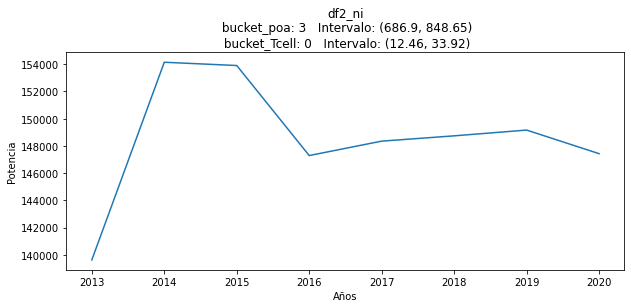

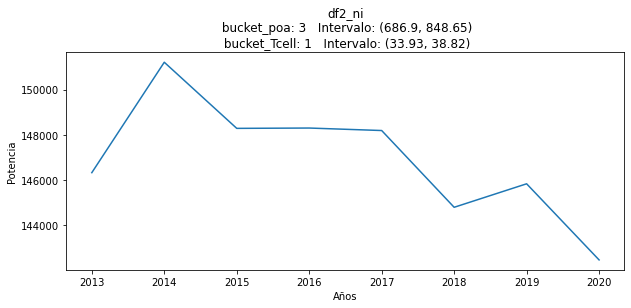

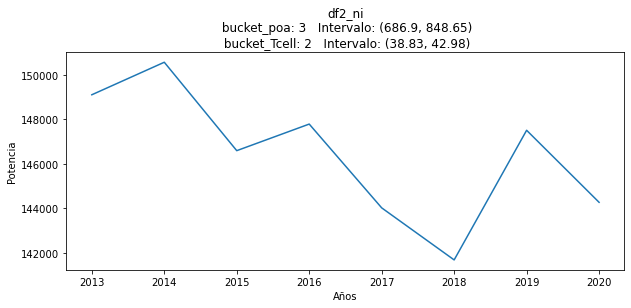

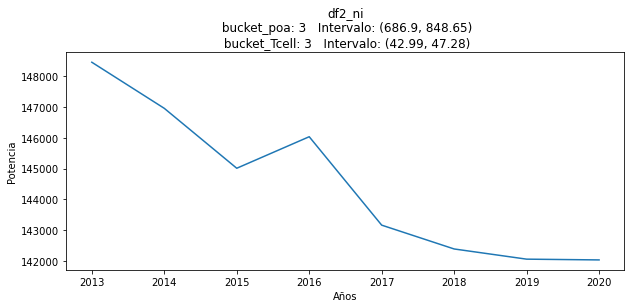

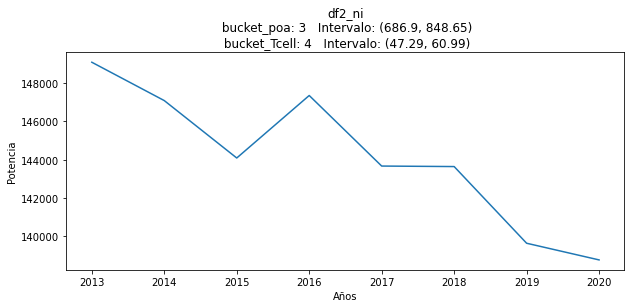

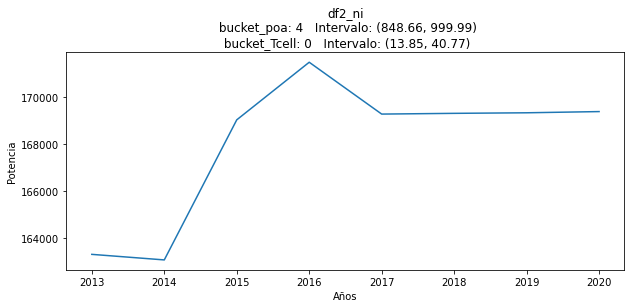

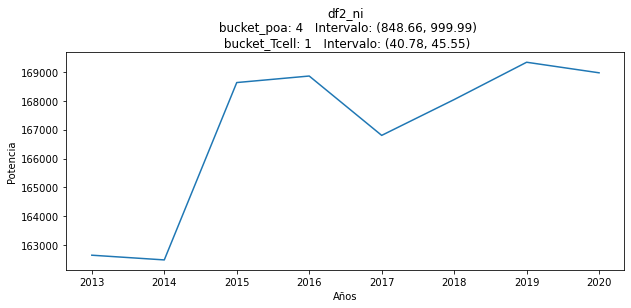

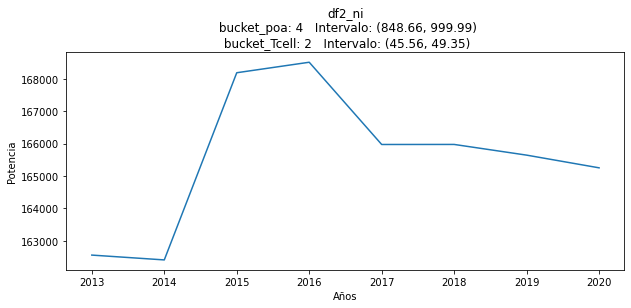

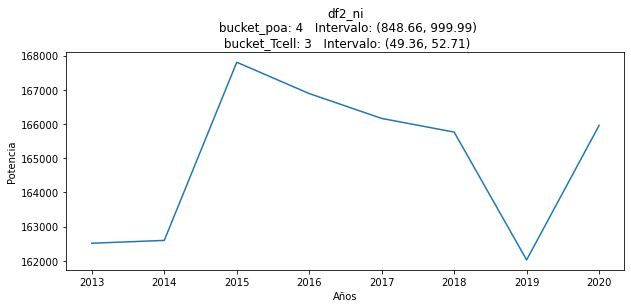

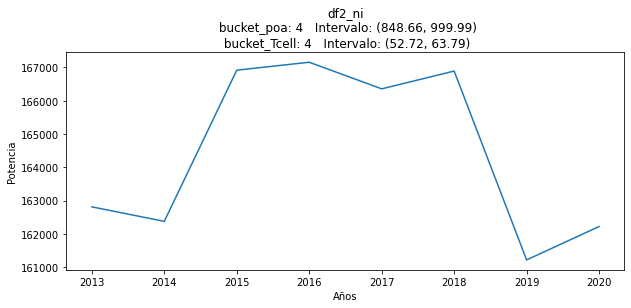

In [6]:
potencia_intervalos, diferencias_intervalos=generar_buckets(poa_200_df2, 5, 5, "df2_ni")

<ipython-input-4-e30c60aa0d60>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bucket_poa"]= b_poa
<ipython-input-4-e30c60aa0d60>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucket_i["bucket_tcell"]= b_tcell


Cada bucket POA tiene el siguiente número de valores: 
1    15353
2    15353
3    15353
4    15353
0    15354
Name: poa, dtype: int64

INTERVALOS POA
 El rango de intervalos del bucket:  0  es:  200.01  -  344.66
 El rango de intervalos del bucket:  1  es:  344.67  -  517.64
 El rango de intervalos del bucket:  2  es:  517.65  -  686.28
 El rango de intervalos del bucket:  3  es:  686.29  -  847.1
 El rango de intervalos del bucket:  4  es:  847.15  -  999.99

[(200.01, 344.66), (344.67, 517.64), (517.65, 686.28), (686.29, 847.1), (847.15, 999.99)]
------------------------------------------------

Cada bucket TCELL tiene el siguiente número de valores: 
4    3068
3    3069
1    3070
2    3072
0    3075
Name: Tcell, dtype: int64

INTERVALOS TCELL

[(0.44, 18.81), (18.82, 23.32), (23.33, 27.49), (27.5, 32.09), (32.1, 46.46)]

------------------------------------------------
Cada bucket TCELL tiene el siguiente número de valores: 
3    3064
1    3068
4    3071
0    3074
2    3076
Name: Tc

<ipython-input-4-e30c60aa0d60>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,4))


------------------------------------------------

Numero bucket poa:  4
Numero bucket Tcell:  1

Tamaño del bucket:  3072  valores

medianas_power  [162992.00890000002, 162819.93, 169255.4031, 167126.53600000002, 167381.49, 164955.90800000002, 168823.516, 167765.39445]

La diferencia entre el primer y el ultimo año:  0.41837156682137694  % es menor al 1%

Diferencias:
[0.10557505313379952, 3.952509437880242, 1.2577838349669643, 0.15255147752237788, 1.4491339514303319, 2.344631390832014, 0.6267619435197705]
------------------------------------------------

Numero bucket poa:  4
Numero bucket Tcell:  2

Tamaño del bucket:  3074  valores

medianas_power  [162808.32, 162621.08000000002, 168738.24, 166294.2411, 164942.1839, 162381.0431, 164753.02800000002, 164373.46200000006]

La diferencia entre el primer y el ultimo año:  0.13733432928103523  % es menor al 1%

Diferencias:
[0.11500640753494089, 3.7616033542514744, 1.4483965815928725, 0.813051126158337, 1.5527506302164304, 1.46075234812924

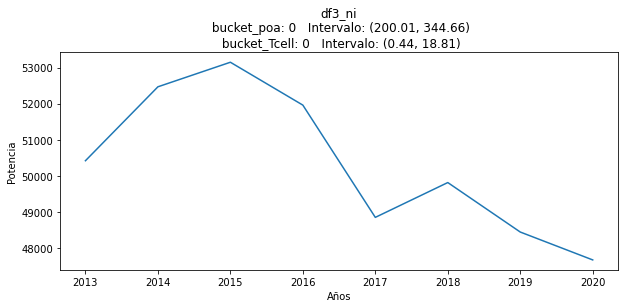

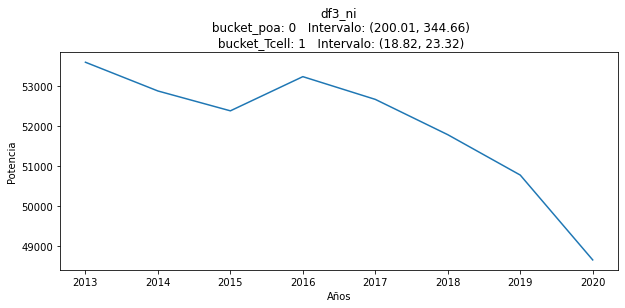

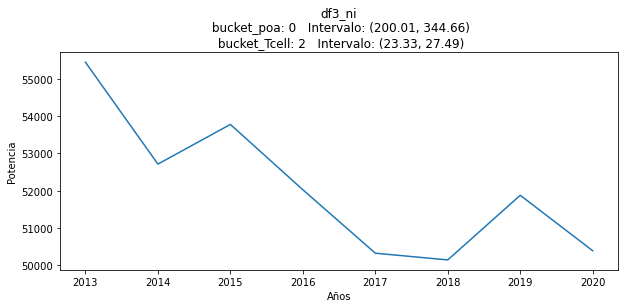

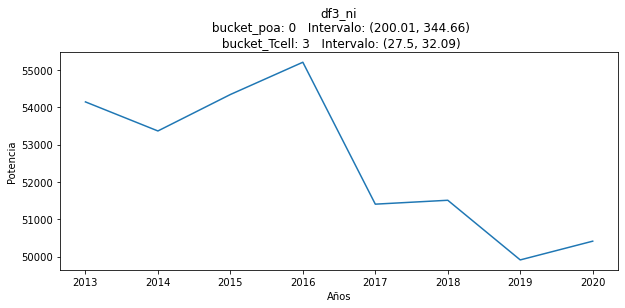

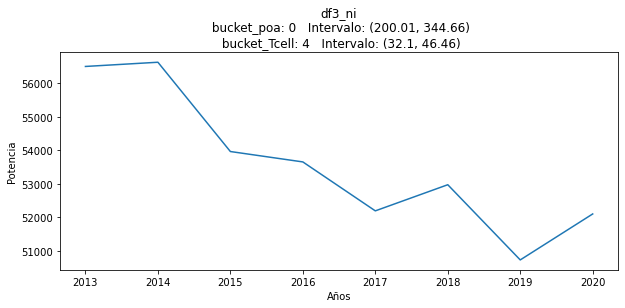

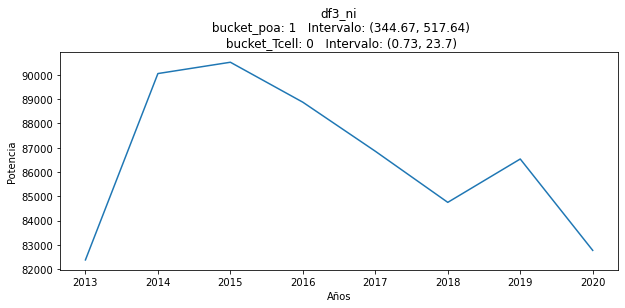

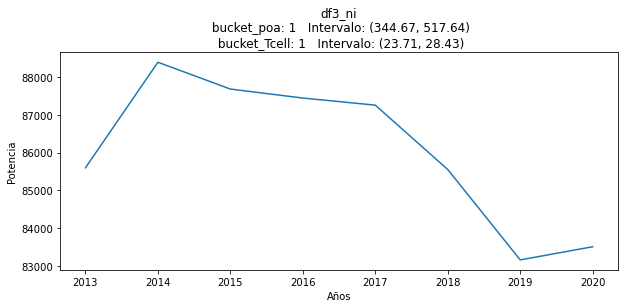

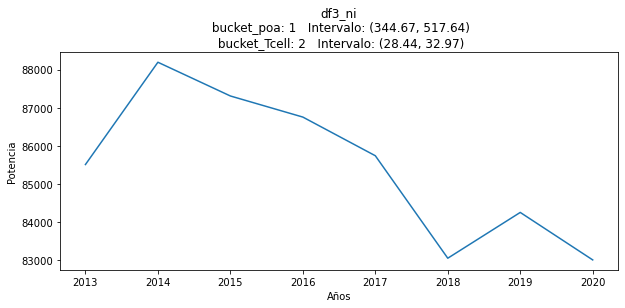

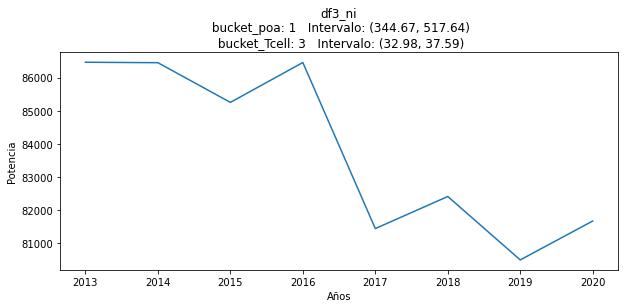

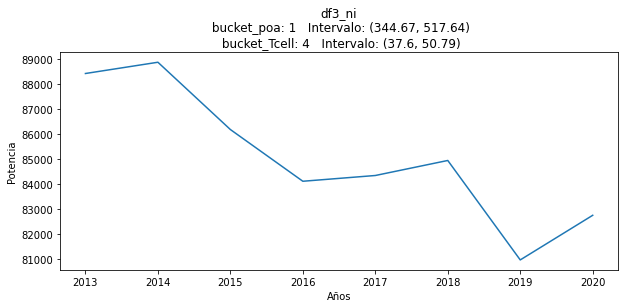

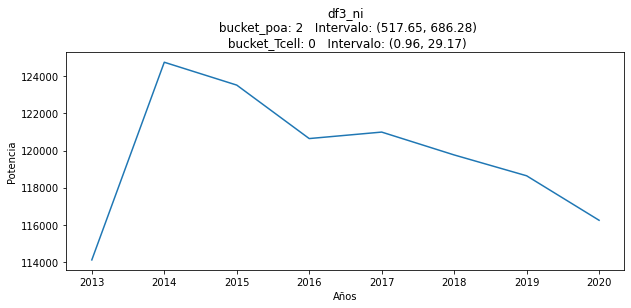

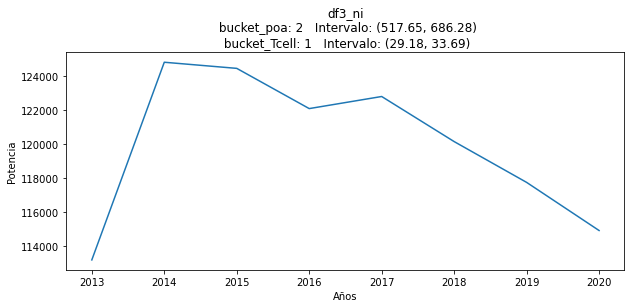

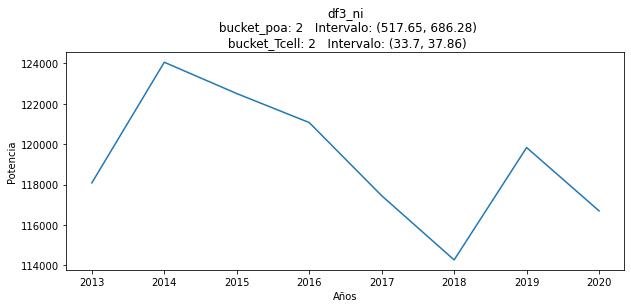

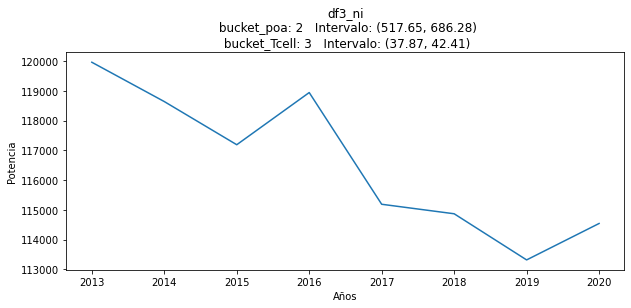

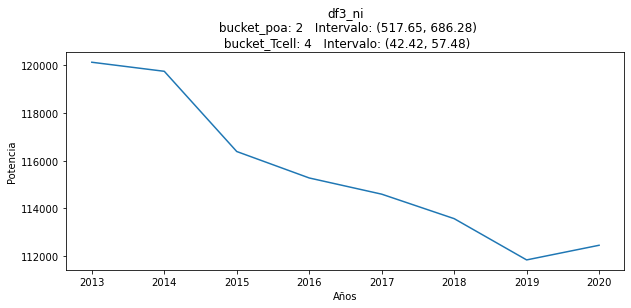

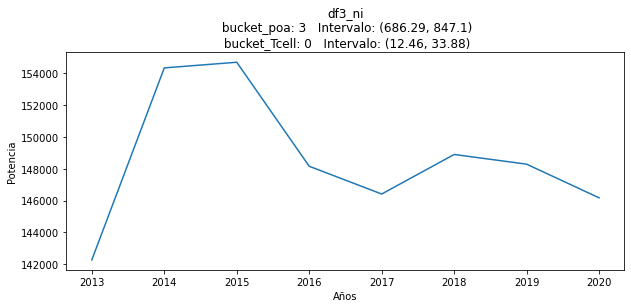

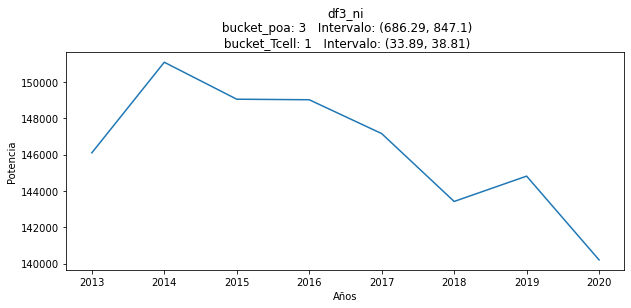

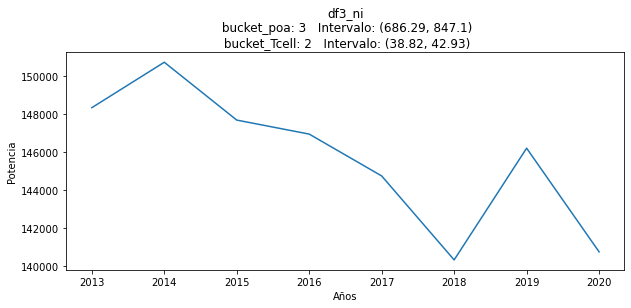

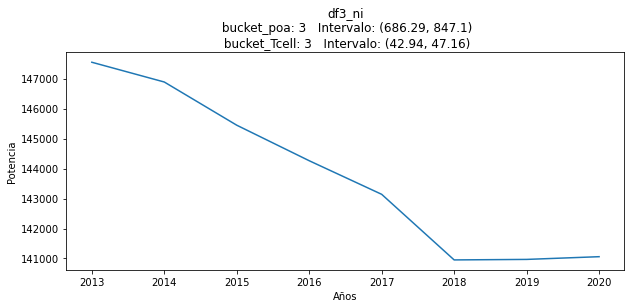

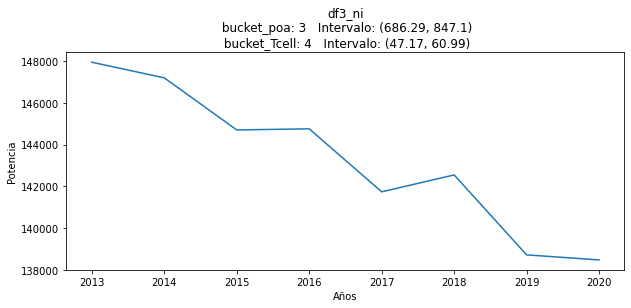

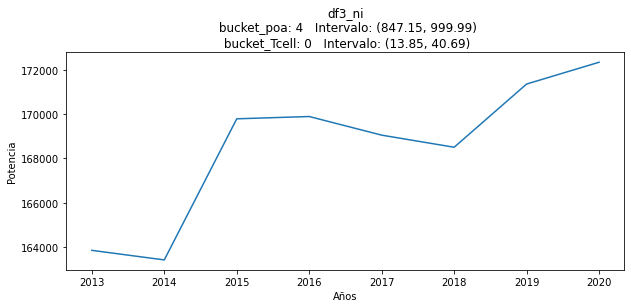

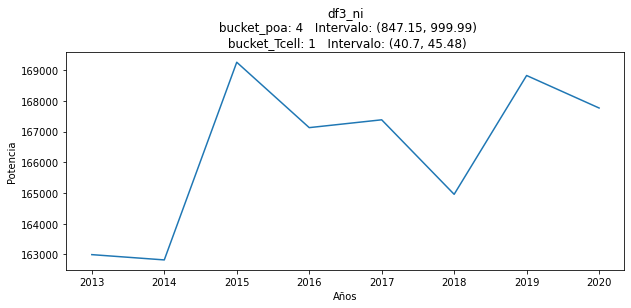

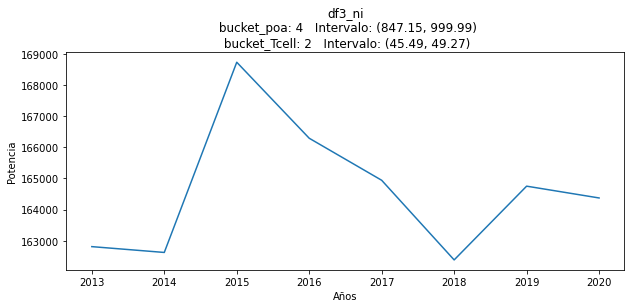

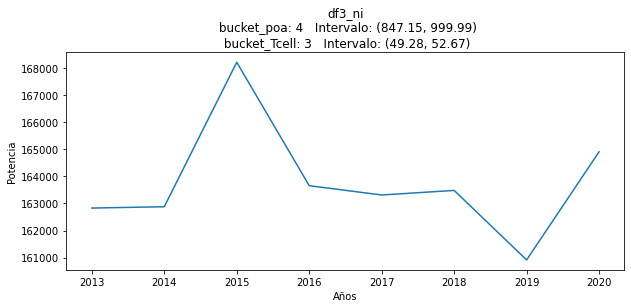

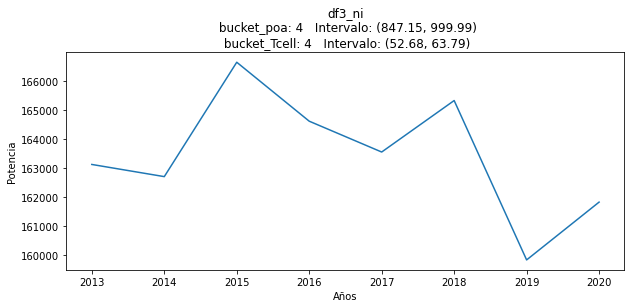

In [7]:
potencia_intervalos, diferencias_intervalos=generar_buckets(poa_200_df3, 5, 5, "df3_ni")

<ipython-input-4-e30c60aa0d60>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bucket_poa"]= b_poa
<ipython-input-4-e30c60aa0d60>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bucket_i["bucket_tcell"]= b_tcell


Cada bucket POA tiene el siguiente número de valores: 
3    15430
0    15432
1    15432
4    15432
2    15433
Name: poa, dtype: int64

INTERVALOS POA
 El rango de intervalos del bucket:  0  es:  200.01  -  344.9
 El rango de intervalos del bucket:  1  es:  344.94  -  517.94
 El rango de intervalos del bucket:  2  es:  517.95  -  685.74
 El rango de intervalos del bucket:  3  es:  685.75  -  846.8
 El rango de intervalos del bucket:  4  es:  846.81  -  999.99

[(200.01, 344.9), (344.94, 517.94), (517.95, 685.74), (685.75, 846.8), (846.81, 999.99)]
------------------------------------------------

Cada bucket TCELL tiene el siguiente número de valores: 
3    3083
4    3085
2    3086
1    3087
0    3091
Name: Tcell, dtype: int64

INTERVALOS TCELL

[(0.44, 18.81), (18.82, 23.31), (23.32, 27.5), (27.51, 32.12), (32.13, 46.46)]

------------------------------------------------
Cada bucket TCELL tiene el siguiente número de valores: 
2    3082
3    3082
4    3086
0    3090
1    3092
Name: Tce

<ipython-input-4-e30c60aa0d60>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,4))


------------------------------------------------

Numero bucket poa:  4
Numero bucket Tcell:  1

Tamaño del bucket:  3086  valores

medianas_power  [161970.336, 161272.06110000002, 161942.788, 159326.50345000002, 160073.0829, 159923.02610000002, 160816.08645000003, 160201.4091]

La diferencia entre el primer y el ultimo año:  0.1560185951933481  % es menor al 1%

Diferencias:
[0.43111283043827814, 0.41589776643586257, 1.6155610152889193, 0.46858459442328904, 0.09374268133121036, 0.5584313727540291, 0.3822237958707903]
------------------------------------------------

Numero bucket poa:  4
Numero bucket Tcell:  2

Tamaño del bucket:  3091  valores

medianas_power  [162157.0671, 159779.3229, 160542.6909, 157633.046, 158393.83344999998, 156242.66555, 157020.24, 157170.69245000003]

La diferencia entre el primer y el ultimo año:  0.4392896643073777  % es menor al 1%

Diferencias:
[1.466321661166741, 0.4777639472647857, 1.8123807964651382, 0.48263195396222586, 1.3581134146103158, 0.49767100

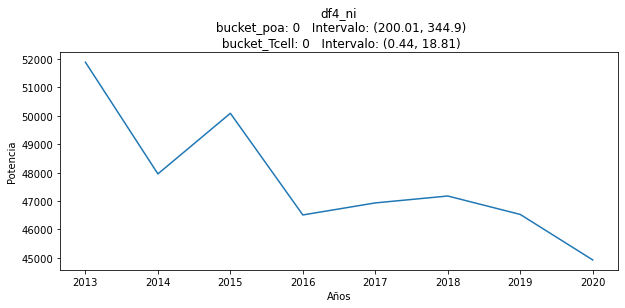

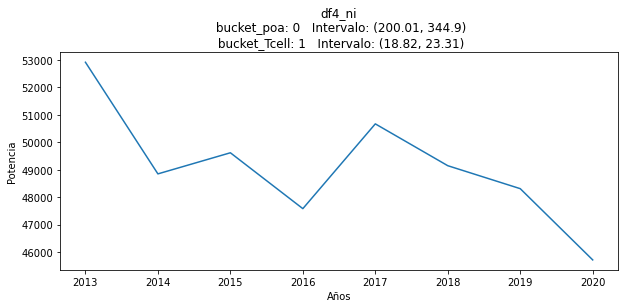

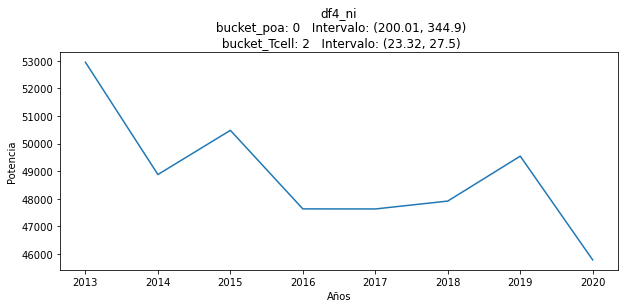

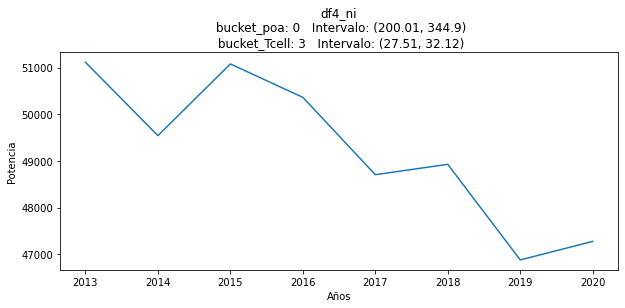

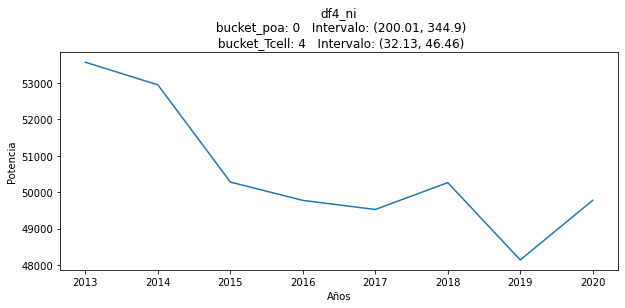

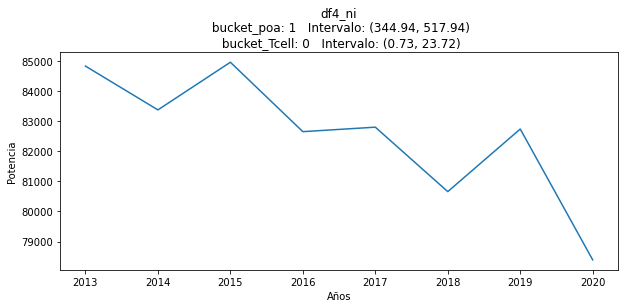

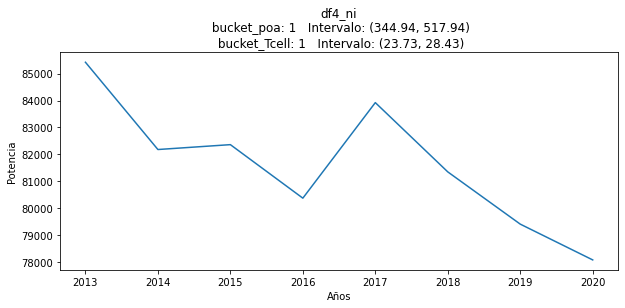

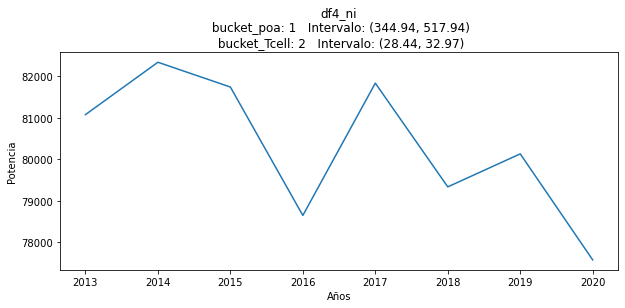

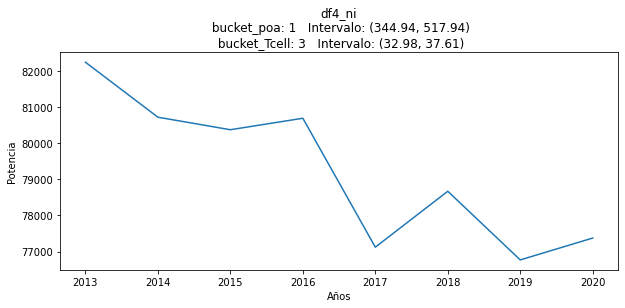

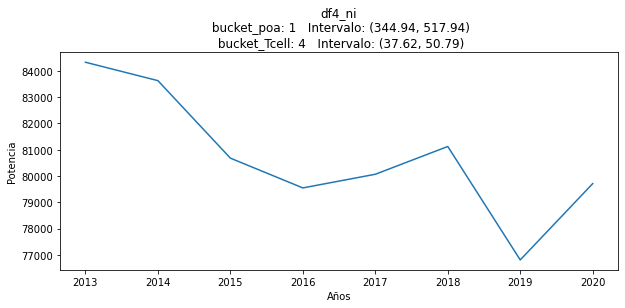

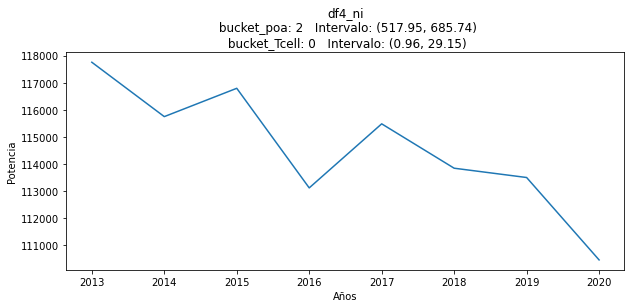

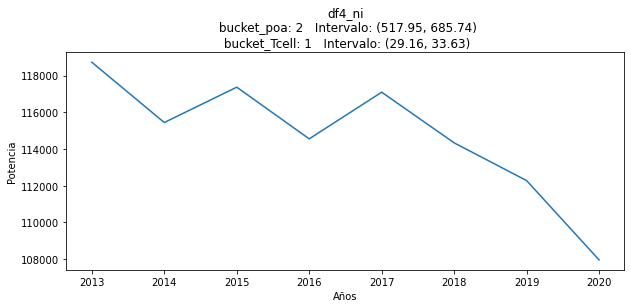

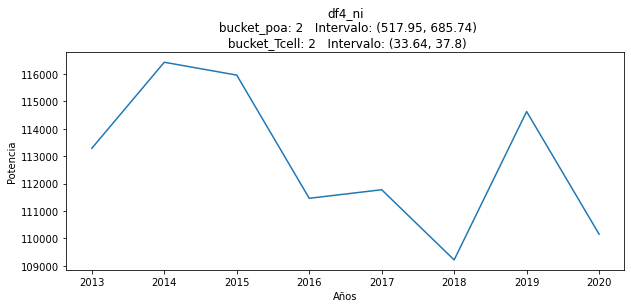

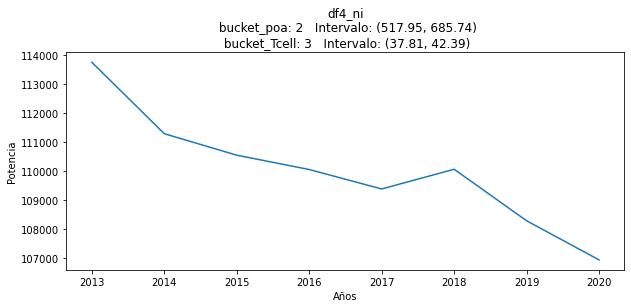

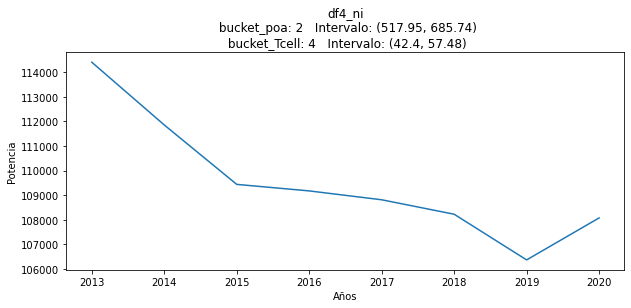

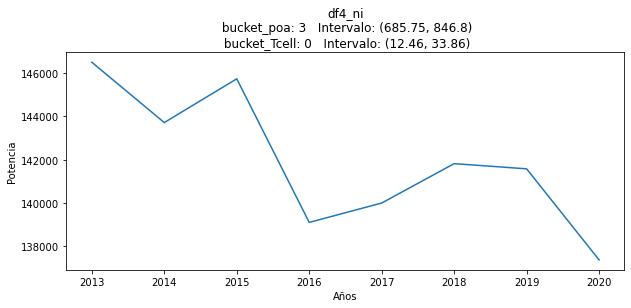

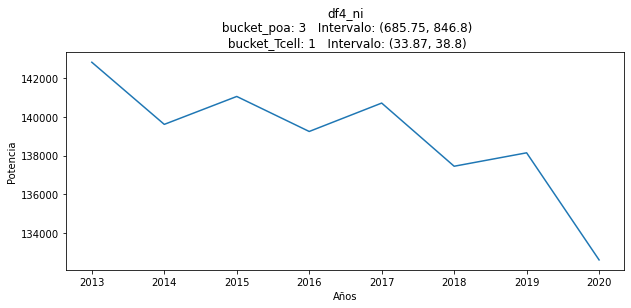

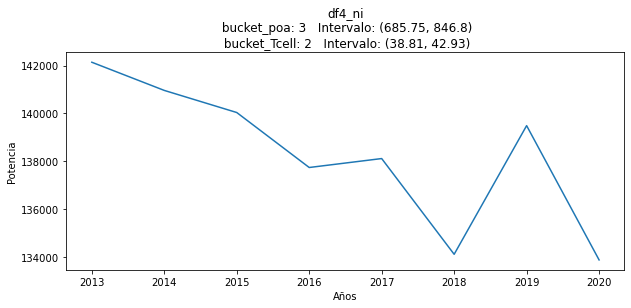

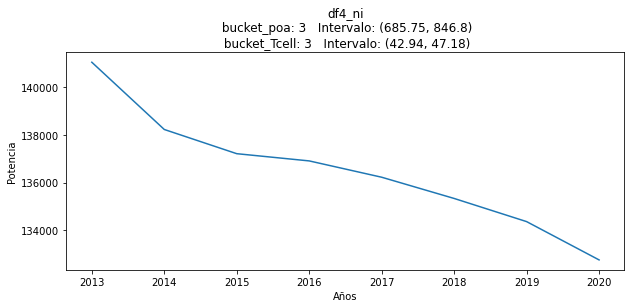

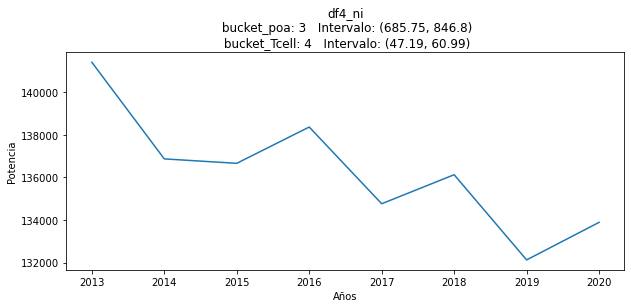

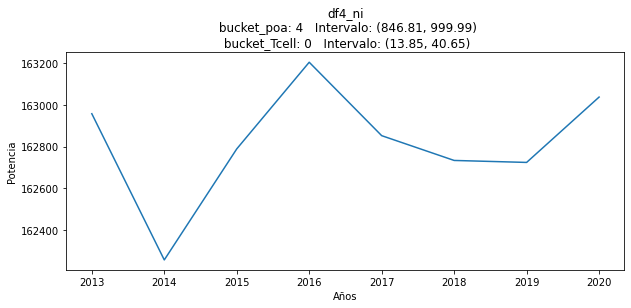

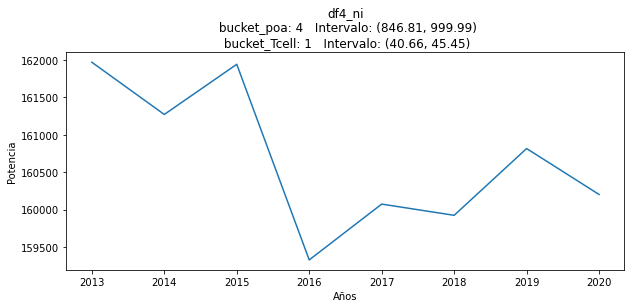

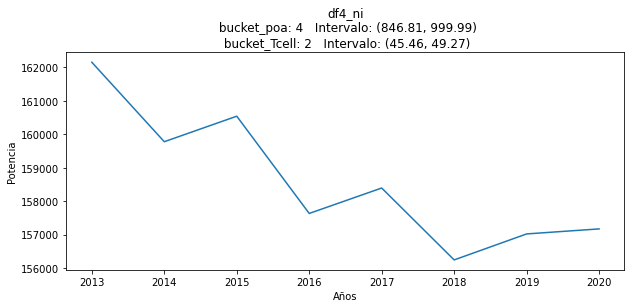

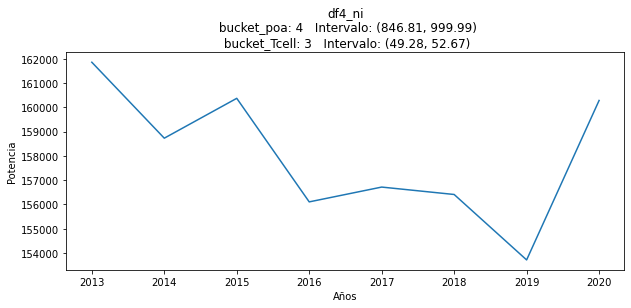

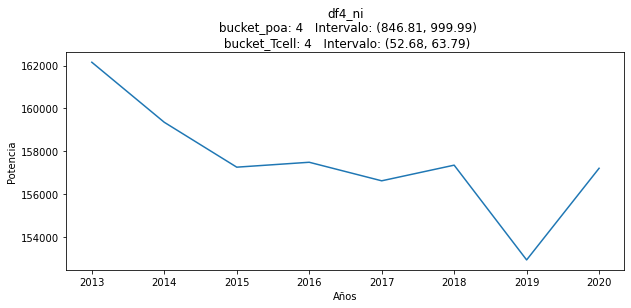

In [8]:
potencia_intervalos, diferencias_intervalos=generar_buckets(poa_200_df4, 5, 5, "df4_ni")

In [9]:
#CALCULAR LA MEDIA DE LAS DIFERENCIAS

bins_poa= 5
bins_tcell= 5
celdas=bins_poa * bins_tcell

def calcular_media(lista):
    return sum(lista) / len(lista)

todos_valores_dif=[]
media_de_diferencias=[]

for x in range(7):
    for i in range(celdas):
        
        #DIFERENCIAS
        valor_dif=diferencias_intervalos[i][x]
        todos_valores_dif.append(valor_dif)
          
    #DIFERENCIAS 
    media_dif=calcular_media(todos_valores_dif)
    media_de_diferencias.append(media_dif)
    #print(media)

Diferencia potencia entre 2013-2014: 2.590258036297048 %
Diferencia potencia entre 2014-2015: 2.0471273326792896 %
Diferencia potencia entre 2015-2016: 2.1053945943131134 %
Diferencia potencia entre 2016-2017: 1.9553687777737363 %
Diferencia potencia entre 2017-2018: 1.849858814662782 %
Diferencia potencia entre 2018-2019: 1.8943800906924928 %
Diferencia potencia entre 2019-2020: 2.023185829381717 %


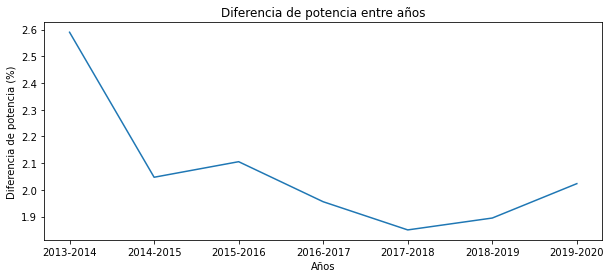

In [10]:

dif_años=['2013-2014', '2014-2015','2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020']
b=0
for i in dif_años:
    print("Diferencia potencia entre " + i + ": " + str(media_de_diferencias[b]) + " %")
    b=b+1

titulo="Diferencia de potencia entre años"
representar_graficas(dif_años, media_de_diferencias, titulo, 'Diferencia de potencia (%)')

In [11]:
#CALCULAR LA MEDIA DE LAS POTENCIAS

todos_valores_pow=[]
media_de_pow=[]

numero_años=8

for x in range(numero_años):
    for i in range(celdas):
        
        #POTENCIAS
        valor_pow=potencia_intervalos[i][x]
        todos_valores_pow.append(valor_pow)
        
    #POTENCIAS
    media_pow=calcular_media(todos_valores_pow)
    media_de_pow.append(media_pow)

Media de Potencia de los 25 intervalos en el año: 2013 es: 111331.50706400002 W
Media de Potencia de los 25 intervalos en el año: 2014 es: 110304.92150800001 W
Media de Potencia de los 25 intervalos en el año: 2015 es: 110008.17283533333 W
Media de Potencia de los 25 intervalos en el año: 2016 es: 109378.74768000003 W
Media de Potencia de los 25 intervalos en el año: 2017 es: 109072.80810080004 W
Media de Potencia de los 25 intervalos en el año: 2018 es: 108745.71536033337 W
Media de Potencia de los 25 intervalos en el año: 2019 es: 108428.9841545715 W
Media de Potencia de los 25 intervalos en el año: 2020 es: 108058.42789650004 W


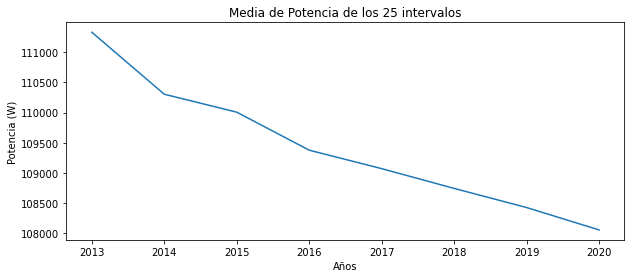

In [12]:
años=['2013', '2014','2015', '2016', '2017', '2018', '2019', '2020']

b=0
for i in años:
    print("Media de Potencia de los " + str(celdas) + " intervalos en el año: " + i + " es: " + str(media_de_pow[b]) + " W")
    b=b+1

titulo="Media de Potencia de los " + str(celdas) + " intervalos"
representar_graficas(años, media_de_pow, titulo, 'Potencia (W)')